# Metaphor Extraction and Classification:

In this Notebook you can find all the methods used to identify, extract and classify conceptual metaphors about inflation.

The methods are:
- Regex
- Part of Speech
- Neural Network
- Large Language Model 

In [5]:
#!pip install ecbdata

In [6]:
import re
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from ecbdata import ecbdata
from textblob import TextBlob
from itertools import product
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import matplotlib.colors as mcolors
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModel, pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer 
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Embedding, GlobalAveragePooling1D

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
warnings.filterwarnings('ignore')

import spacy
sp = spacy.load('en_core_web_sm')

tqdm.pandas()

porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

#ECB Color
color = (17/255, 49/255, 147/255)

# File containing the functions
from src.Metaphor_Detection_Functions import *
from src.Metrics import *

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\School\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\School\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Regex

**Basic Regex:**

To find the conceptual metaphors mentioning "Inflation", we will try to find sentences which contains the word "Inflation" followed or preceeded by any word from a corpus given by the paper: Inflation Metaphor in Contemporary American English.

The corpus contains the 9 roots mentioned in the paper. 

**Choice between Stemming or Lemmatization:**

Stemming: Stemming is generally faster and simpler than lemmatization, but it may not always produce a valid word since it applies simple rules to chop off suffixes. In your case, stemming could potentially match "beat" with "beating" but may produce incorrect results in some cases.

Lemmatization: Lemmatization, on the other hand, maps words to their base or dictionary form, which is more linguistically accurate. It typically requires more computational resources compared to stemming but can provide more accurate results

Select modulation for this notebook:

In [7]:
# mod = 0 means just lowercase, mod = 1 means stemming, mod = 2 means lemmatizing
mod_regex = 2

# Target words:
words_to_match = ["inflation","deflation","inflationary","desinflationary","hyperinflation","disinflation"]

In [8]:
# Import dataset containing the interveiw data
df = pd.read_csv('Data/Final_Data.csv')

# Convert 'date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

print("Shape of the dataset before dropping missing values: ", df.shape)
df.isna().sum()
print("Shape of the dataset after dropping missing values: ", df.shape)
df.nunique()


Shape of the dataset before dropping missing values:  (519, 30)
Shape of the dataset after dropping missing values:  (519, 30)


Unnamed: 0                519
Date                      489
Media                     259
Member                     19
Link                      519
Information               361
Questions                 465
Answers                   509
Metaphors                  59
Metaphors Sentence         59
YoB                        15
Gender                      2
Country                    10
Period on the Board        14
list_regex                407
list_regex_reduced        407
list_regex_len             38
list_regex_reduced_len     38
text_length               504
pos_metaphors             177
pos_metaphors_len          15
Sentences                 406
Frequency                  43
Sentences_len              35
Sentence_GPT_Majority     406
GPT_Majority_Category     308
Matched_Metaphors          60
pos_relationships         307
pos_sentences             242
pos_relationships_len      28
dtype: int64

In [9]:
start = df["Date"].min()
start = start.strftime('%Y-%m')
df2 = ecbdata.get_series('ICP.M.U2.N.000000.4.ANR', 
                        start=start)
df2["TIME_PERIOD"] = pd.to_datetime(df2["TIME_PERIOD"])
print("Start date is: ",start)

Start date is:  2005-01


In [10]:
# List of words to match: (Mix of words from the paper and other sources (e.g. ChatGPT))
as_plant = ['hedge', 'nip', 'bloom', 'sprout', 'grow', 'blossom', 'flower', 'bush', 'shrub', 'leaf', 'petal', 'stem', 'root', 'thorn', 'thistle', 'fern', 'moss', 'ivy', 'vine', 'creeper', 'branch', 'twig', 'sapling', 'seedling', 'trunk', 'foliage', 'lush', 'verdant', 'botany', 'flora', 'pollen', 'nectar', 'pollinate', 'photosynthesis', 'chlorophyll', 'garden', 'orchard', 'nursery', 'weed', 'weedkiller', 'prune', 'trim', 'mulch', 'compost', 'fertilize', 'transplant', 'perennial', 'annual', 'deciduous', 'evergreen', 'shade', 'sunlight', 'water', 'nutrients', 'soil', 'arid', 'drought', 'flood', 'tendril', 'mushroom', 'cactus', 'succulent', 'bark', 'pine', 'oak', 'maple', 'palm', 'lily', 'rose', 'daisy', 'tulip', 'daffodil', 'carnation', 'lawn', 'sod', 'bulb', 'cypress', 'fir', 'ginkgo', 'juniper', 'magnolia', 'willow', 'thistle', 'lilac', 'orchid', 'poppy', 'violet', 'dandelion', 'clover']
as_animal = ['roar', 'pounce', 'stalk', 'attack', 'bite', 'claw', 'snarl', 'charge', 'hunt', 'intimidate', 'defend', 'rend', 'tear', 'dominate', 'fangs', 'claws', 'aggression', 'predation', 'territoriality', 'hackles', 'mane', 'prowess', 'strength', 'ferocity', 'dominance', 'menace', 'threat', 'piercing', 'glaring', 'talons', 'paws', 'beak', 'scales', 'horns', 'tusks', 'quills', 'tail', 'jaws', 'muzzle', 'fierce', 'intimidating', 'savage', 'menacing', 'aggressive', 'predatory', 'dominant', 'territorial', 'formidable', 'ruthless', 'daunting', 'wild', 'ferocious', 'hissing', 'prey', 'teeth', 'savage', 'feral', 'voracious', 'primal', 'untamed', 'predatory', 'beastly', 'wild', 'barbarous', 'fierce', 'wolf', 'leopard', 'snake', 'shark', 'eagle', 'feathers', 'bear', 'bull', 'lion', 'sharp', 'span']
as_liquids = ['erode', 'surge', 'subside', 'simmers', 'emergence', 'ebb', 'dilute', 'spurt', 'recede', 'buoy', 'flow', 'pour', 'drip', 'splash', 'ripple', 'stream', 'trickle', 'cascade', 'gush', 'drain', 'seep', 'soak', 'flood', 'ooze', 'swirl', 'pool', 'droplet', 'melt', 'evaporate', 'condense', 'vaporize', 'liquefy', 'freeze', 'thaw', 'spray', 'mist', 'fountain', 'wave', 'current', 'whirlpool', 'whirl', 'eddy', 'torrent', 'deluge', 'overflow', 'percolate', 'absorb', 'douse', 'immerse', 'saturate', 'slosh', 'quench', 'hydrate', 'teem', 'aquatic', 'viscous', 'fluid', 'liquidation', 'solution', 'solvent', 'moisture', 'hydration', 'reservoir', 'aquifer', 'spring', 'well', 'creek', 'river', 'lake', 'pond', 'ocean', 'sea', 'bay', 'delta', 'waterfall', 'rapids', 'canal', 'channel', 'estuary', 'lagoon', 'fjord', 'gulf', 'marsh', 'swamp', 'bog', 'wetland', 'mud', 'slime', 'silt', 'sediment', 'brine', 'oil', 'gasoline', 'alcohol', 'juice', 'soda', 'milk', 'coffee', 'tea', 'soup']
as_fire = ['ignite', 'fuel', 'spark', 'dampen', 'stoke', 'kindle', 'choke', 'stifle', 'fan', 'flare-up', 'douse', 'snuff', 'blaze', 'burn', 'combust', 'flame', 'inferno', 'smolder', 'char', 'embers', 'ash', 'heat', 'bonfire', 'campfire', 'wildfire', 'arson', 'firefighter', 'fireproof', 'firebreak', 'firewood', 'fireplace', 'firestorm', 'firefighting', 'fireman', 'firetruck', 'firehouse', 'flint', 'match', 'lighter', 'torch', 'camping', 'smoke', 'smokestack', 'soot', 'scorched', 'scorching', 'singe', 'conflagration', 'incendiary', 'pyre', 'safety', 'extinguish', 'hose', 'hydrant', 'alarm', 'evacuate', 'emergency', 'inferno', 'combustion', 'heatwave', 'smoke detector', 'fire blanket', 'fire escape', 'fire prevention', 'fire drill', 'firecracker', 'fireworks', 'fire brigade', 'fire marshal', 'fire trail', 'fire station', 'fire pit', 'fireworks display', 'smoke alarm', 'fire-retardant']
as_disease = ['plague', 'worsen', 'benign', 'virulent', 'debilitate', 'bout', 'chronically', 'illness', 'sickness', 'infection', 'malady', 'ailment', 'condition', 'syndrome', 'disorder', 'pathogen', 'virus', 'bacteria', 'parasite', 'fungus', 'contagion', 'epidemic', 'pandemic', 'outbreak', 'transmission', 'spread', 'symptoms', 'fever', 'cough', 'cold', 'flu', 'fatigue', 'weakness', 'nausea', 'vomiting', 'diarrhea', 'headache', 'muscle', 'pain', 'aches', 'chills', 'rash', 'inflammation', 'swelling', 'lesion', 'ulcer', 'scar', 'tumor', 'cancer', 'metastasis', 'diagnosis', 'treatment', 'therapy', 'medication', 'prescription', 'antibiotic', 'antiviral', 'antifungal', 'antibacterial', 'immunization', 'vaccination', 'immunity', 'immune', 'response', 'resistance', 'susceptibility', 'prevention', 'control', 'management', 'prognosis', 'recovery', 'remission', 'relapse', 'complication', 'morbidity', 'mortality', 'patient', 'doctor', 'nurse', 'hospital', 'clinic', 'emergency', 'ward', 'ICU', 'intensive care', 'healthcare', 'public health', 'epidemiology', 'palliative', 'care', 'hospice', 'quarantine', 'isolation']
as_warfare = ['threat', 'subdue', 'target', 'beat', 'preempt', 'vigilant', 'ravage', 'undermine', 'forestall', 'counteract', 'eliminate', 'ferocious', 'ruinous', 'clobber', 'buster', 'eradicate', 'besieged', 'thwart', 'bash', 'beset', 'combat', 'conflict', 'battle', 'war', 'fight', 'engagement', 'skirmish', 'confrontation', 'hostilities', 'assault', 'offensive', 'defense', 'siege', 'ambush', 'raid', 'invasion', 'occupation', 'conquest', 'resistance', 'surrender', 'victory', 'defeat', 'truce', 'ceasefire', 'armistice', 'escalation', 'deescalation', 'escalate', 'deescalate', 'strategy', 'tactics', 'battlefield', 'frontline', 'troops', 'soldiers', 'military', 'army', 'navy', 'airforce', 'marines', 'commander', 'general', 'officer', 'captain', 'sergeant', 'private', 'weapon', 'firearm', 'ammunition', 'bomb', 'missile', 'tank', 'artillery', 'aircraft', 'warship', 'submarine', 'helicopter', 'drone', 'grenade', 'explosive', 'grenade launcher', 'mine', 'landmine', 'grenade', 'bayonet', 'rifle', 'machine gun', 'sniper', 'artillery', 'barrage', 'bombardment', 'naval', 'air', 'ground', 'infantry', 'cavalry', 'special forces', 'guerrilla', 'insurgent', 'terrorist', 'paramilitary', 'mercenary']
as_sports = ['pace', 'outstrip', 'lag', 'surpass', 'quicken', 'outrun', 'bout', 'best', 'tug-of-war', 'zip', 'overtake', 'athletics', 'competition', 'game', 'match', 'tournament', 'contest', 'event', 'race', 'contestant', 'athlete', 'player', 'team', 'coach', 'referee', 'umpire', 'spectator', 'fan', 'supporter', 'stadium', 'arena', 'field', 'court', 'pitch', 'track', 'course', 'rink', 'ring', 'gymnasium', 'arena', 'field', 'court', 'pitch', 'track', 'course', 'rink', 'ring', 'gymnasium', 'training', 'practice', 'warm-up', 'stretching', 'conditioning', 'exercise', 'regimen', 'drill', 'workout', 'routine', 'warm-up', 'stretching', 'conditioning', 'exercise', 'regimen', 'drill', 'workout', 'routine', 'skill', 'technique', 'strategy', 'tactics', 'formation', 'play', 'move', 'pass', 'shoot', 'score', 'goal', 'point', 'touchdown', 'field goal', 'home run', 'strike', 'spare', 'winner', 'champion', 'victory', 'defeat', 'loss', 'tie', 'draw', 'league', 'division', 'conference', 'championship', 'medal', 'trophy', 'cup', 'prize', 'award', 'record', 'achievement', 'personal best', 'world record', 'fanfare', 'celebration', 'cheer', 'applause', 'ovation', 'boo', 'jeer', 'heckle', 'penalty', 'foul', 'infringement', 'violation', 'suspension', 'ejection', 'injury', 'concussion', 'recovery', 'rehabilitation', 'comeback', 'retirement', 'retirement', 'honor', 'hall of fame', 'legacy', 'heritage']
as_machine = ['accelerate', 'faster', 'control', 'slow', 'trigger', 'skyrocket', 'rapid', 'heat', 'escalate', 'decelerate', 'ratchet', 'unchecked', 'readjusted', 'chug', 'damper', 'zoom', 'mechanism', 'device', 'apparatus', 'equipment', 'tool', 'instrument', 'contraption', 'gadget', 'appliance', 'machine', 'engine', 'motor', 'generator', 'robot', 'robotics', 'automation', 'mechanical', 'electronic', 'hydraulic', 'pneumatic', 'gear', 'lever', 'switch', 'button', 'dial', 'knob', 'control panel', 'interface', 'circuit', 'sensor', 'detector', 'monitor', 'display', 'screen', 'dashboard', 'console', 'keyboard', 'mouse', 'joystick', 'controller', 'remote', 'program', 'software', 'hardware', 'firmware', 'algorithm', 'code', 'data', 'input', 'output', 'processing', 'memory', 'storage', 'transmission', 'communication', 'network', 'connectivity', 'wireless', 'wired', 'interface', 'interface', 'plug', 'socket', 'port', 'connector', 'adapter', 'cable', 'wire', 'electricity', 'power', 'energy', 'current', 'voltage', 'resistance', 'circuitry', 'circuit board', 'microprocessor', 'microcontroller', 'chip', 'component', 'part', 'assembly', 'maintenance', 'repair', 'service', 'upgrade', 'modification', 'installation', 'operation', 'function', 'performance', 'efficiency', 'reliability', 'durability', 'safety', 'security']
as_orientation = ['low', 'rise', 'high', 'increase', 'reduce', 'decline', 'fall', 'exceed', 'spiral', 'hyper', 'upward', 'uptick', 'boost', 'peak', 'diminish', 'upturn', 'hike', 'plummet', 'upswing', 'elevate', 'ascend', 'ascendancy', 'descendancy', 'progress', 'regress', 'advance', 'retreat', 'downward', 'incline', 'decline', 'descent', 'climb', 'drop', 'escalate', 'deescalate', 'soar', 'plunge', 'surge', 'dip', 'slump', 'peak', 'trough', 'crest', 'valley', 'mount', 'sink', 'ascent', 'gain', 'loss', 'progression', 'regression', 'motion', 'movement', 'forward', 'backward', 'onward', 'trend', 'trajectory', 'direction', 'orientation', 'course', 'path', 'route', 'track', 'road', 'way', 'journey', 'voyage', 'migration', 'flow', 'flux', 'shift', 'change', 'variation', 'alteration', 'transition', 'conversion', 'transformation']

as_words = as_fire + as_liquids + as_plant + as_animal + as_disease + as_warfare + as_sports + as_machine + as_orientation
print("Length of the list of words to match: ", len(as_words))
as_words = tokenize_word_list(as_words, mod_regex) # With lemmatization for regex matching
df = preprocess_text_regex(df, mod_regex)

Length of the list of words to match:  853


100%|██████████| 519/519 [04:24<00:00,  1.96it/s]


### Regular Expressions Matcher

In [11]:
# This adds the list of sentences containing the words to match in a new column
regex_match = (df.Answers_cleaned.apply(lambda x: regex_matcher(x, as_words, words_to_match)))
df["list_regex"] = regex_match

# Reduced regex matcher
regex_match = (df.Answers_cleaned.apply(lambda x: regex_matcher_word_order(x, as_words, words_to_match)))
df["list_regex_reduced"] = regex_match

df['list_regex_len'] = df['list_regex'].apply(len)
df['list_regex_reduced_len'] = df['list_regex_reduced'].apply(len)
df['text_length'] = df['Answers'].apply(get_length)

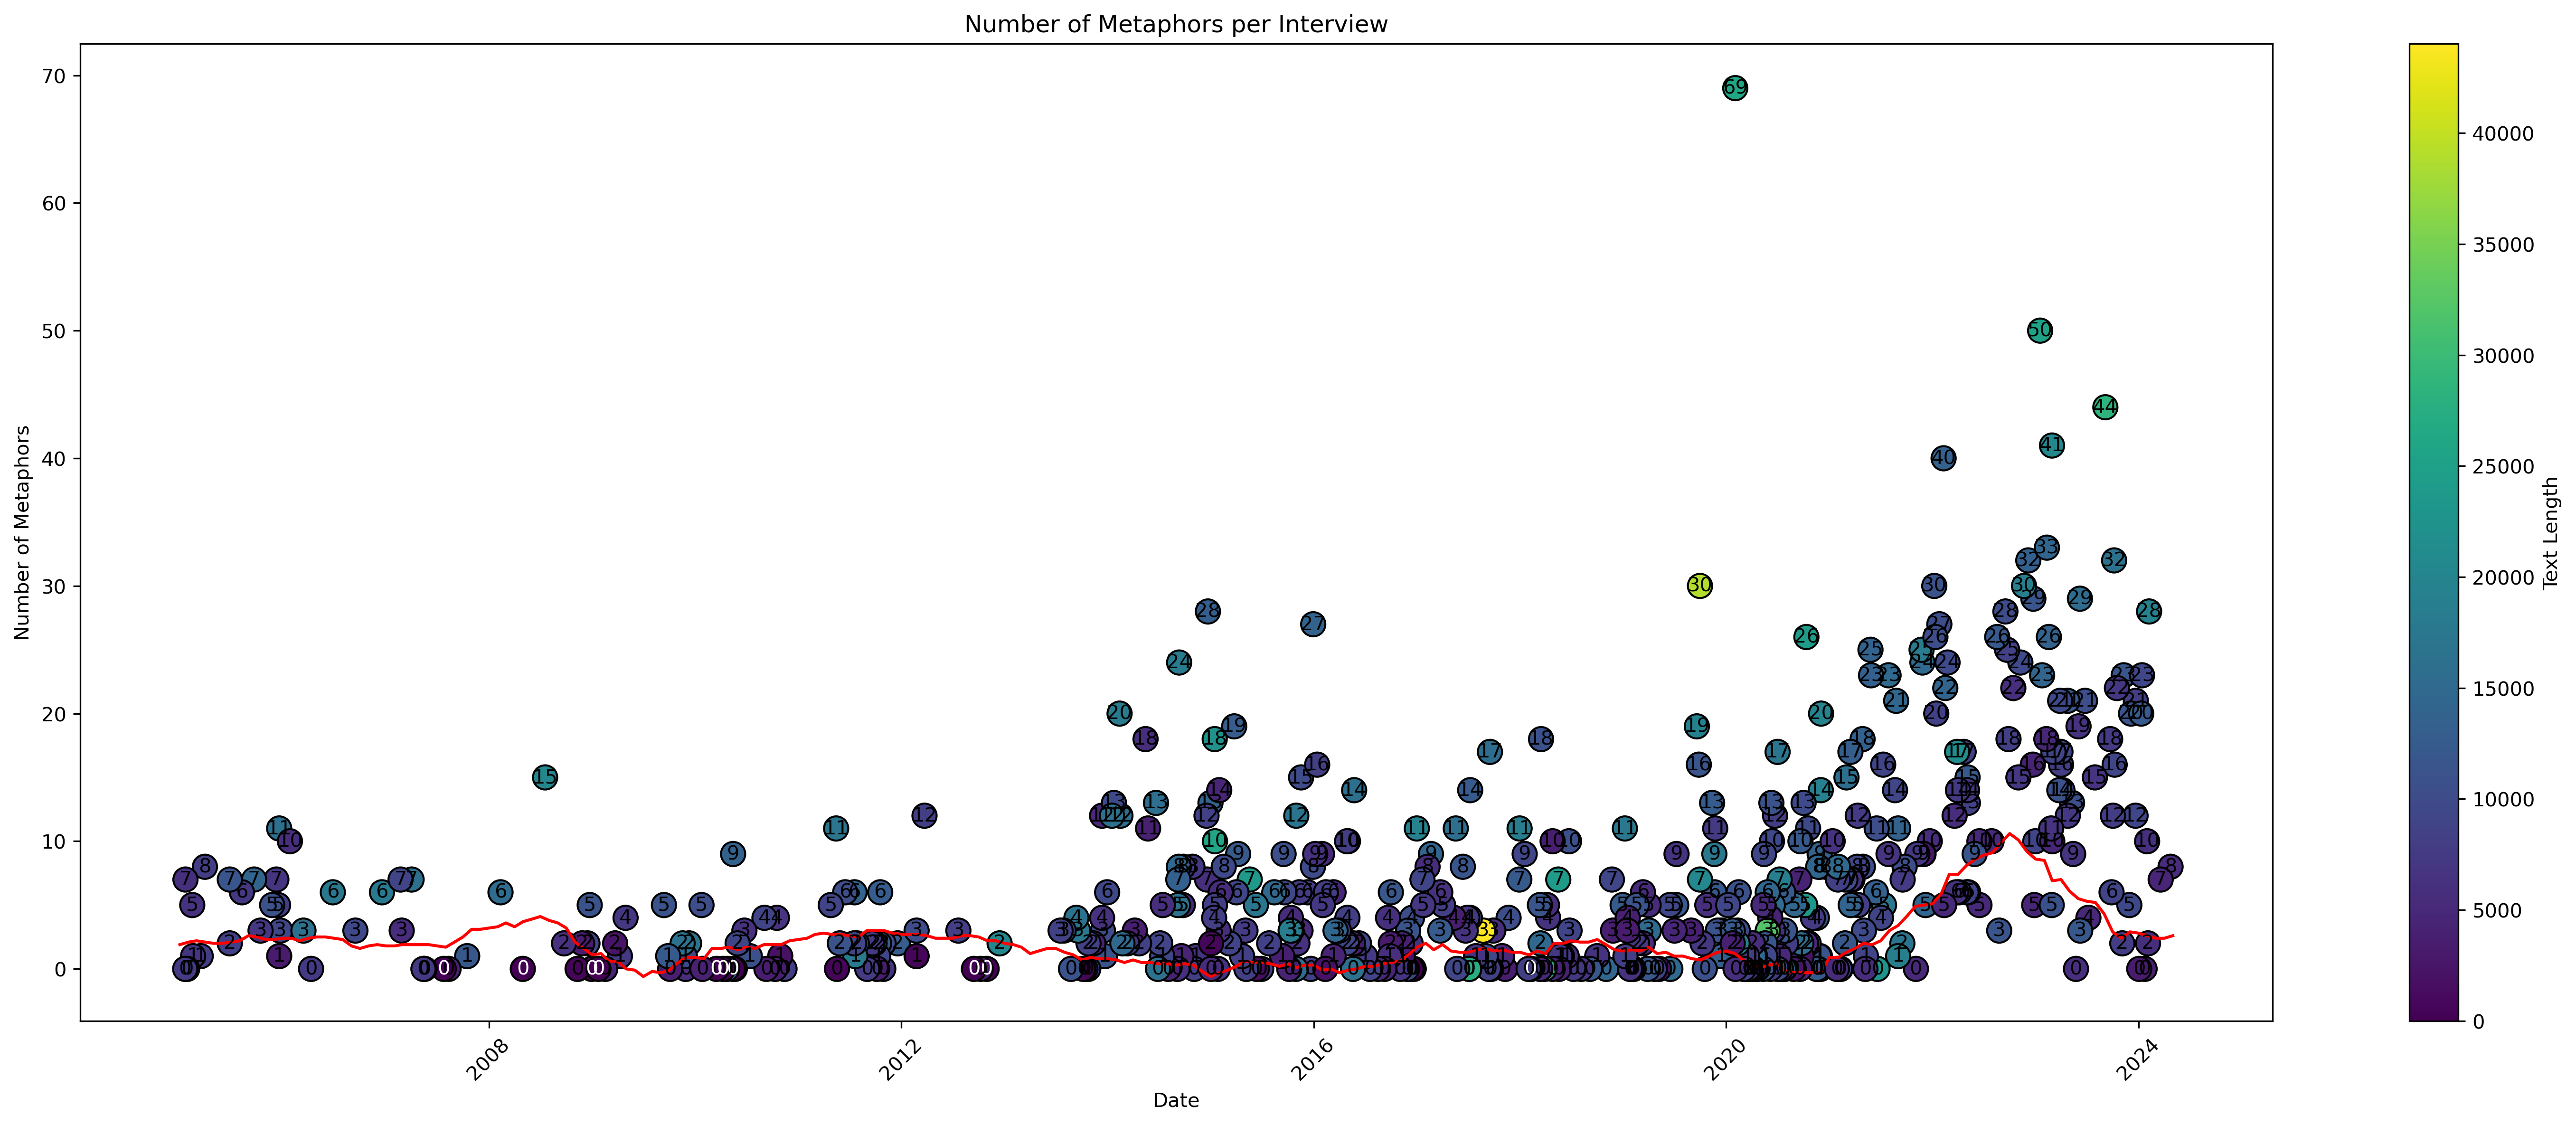

In [12]:
# Defining colors based on text length
norm = mcolors.Normalize(vmin=df['text_length'].min(), vmax=df['text_length'].max())
cmap = plt.cm.get_cmap('viridis')

# Create figure and axes
fig, ax = plt.subplots(figsize=(20, 8), dpi=300)

# Create scatter plot
sc = ax.scatter(df['Date'], df['list_regex_len'], c=df['text_length'], cmap=cmap, norm=norm, s=150, edgecolors='k')

# Add text length colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(df['text_length'])  # Set array to be the range of the colormap
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Text Length')

# Add metaphor count labels inside the points
for i, row in df.iterrows():
    ax.text(row['Date'], row['list_regex_len'], str(row['list_regex_len']), ha='center', va='center', color='white' if row['text_length'] < 0.5 else 'black')

# Plot line for OBS_VALUE from df2
ax.plot(df2['TIME_PERIOD'], df2['OBS_VALUE'], color='red', label='OBS_VALUE')

# Set plot labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Number of Metaphors')
ax.set_title('Number of Metaphors per Interview')

# Rotate x-axis labels for better readability
ax.tick_params(axis='x', rotation=45)

# Show plot
plt.tight_layout()
plt.show()

In [13]:
"""# Save the dataframe
df = df.drop(columns=['Answers_cleaned'])
df.to_csv("Final_Data.csv", index=False)"""

'# Save the dataframe\ndf = df.drop(columns=[\'Answers_cleaned\'])\ndf.to_csv("Final_Data.csv", index=False)'

# Part of Speech (POS)

Use POS to keep only specific adjective-noun, verb-object and subject-verb relationships focusing on "inflation" as noun.

In [14]:
# mod = 0 means just lowercase, mod = 1 means stemming, mod = 2 means lemmatizing
mod_pos = 2

# Target words:
words_to_match = ["inflation","deflation","inflationary","desinflationary","hyperinflation","disinflation"]

In [15]:
# Import dataset containing the interveiw data
df = pd.read_csv('Data/Final_Data.csv')

# Convert 'date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

df.head()

as_words = as_fire + as_liquids + as_plant + as_animal + as_disease + as_warfare + as_sports + as_machine + as_orientation
print("Length of the list of words to match: ", len(as_words))

as_words = tokenize_word_list(as_words) # Without any pruning for pos tagging
# Depending on the modulation, the list of words to match will be different, remove the duplicates
unique_words = remove_duplicates(as_words)
df = preprocess_text_pos(df, words_to_match, True)

Length of the list of words to match:  853
Unique words: 795


100%|██████████| 519/519 [00:00<00:00, 47310.35it/s]


100%|██████████| 519/519 [01:34<00:00,  5.50it/s]


In [16]:
# The list of words can now lemmed or stemmed to match more words in the relationships
as_words = tokenize_word_list(as_words, mod_pos)
df["pos_metaphors"] = df["pos_relationships"].apply(lambda relationships: find_metaphors_in_relationships(relationships, as_words ,mod_pos))
df["pos_metaphors"]

0      [inflationary expectation, inflation affect, i...
1                                                     []
2      [future inflation, low inflation, current infl...
3        [inflationary remain, inflationary expectation]
4                                     [inflation regard]
                             ...                        
514    [inflation fight, inflation abate, inflation r...
515                                                   []
516    [core inflation, high inflation, high inflatio...
517    [inflation fall, inflation reach, inflation ea...
518                                                   []
Name: pos_metaphors, Length: 519, dtype: object

In [17]:
df['pos_metaphors_len'] = df['pos_metaphors'].apply(len)
df['pos_relationships_len'] = df['pos_relationships'].apply(len)

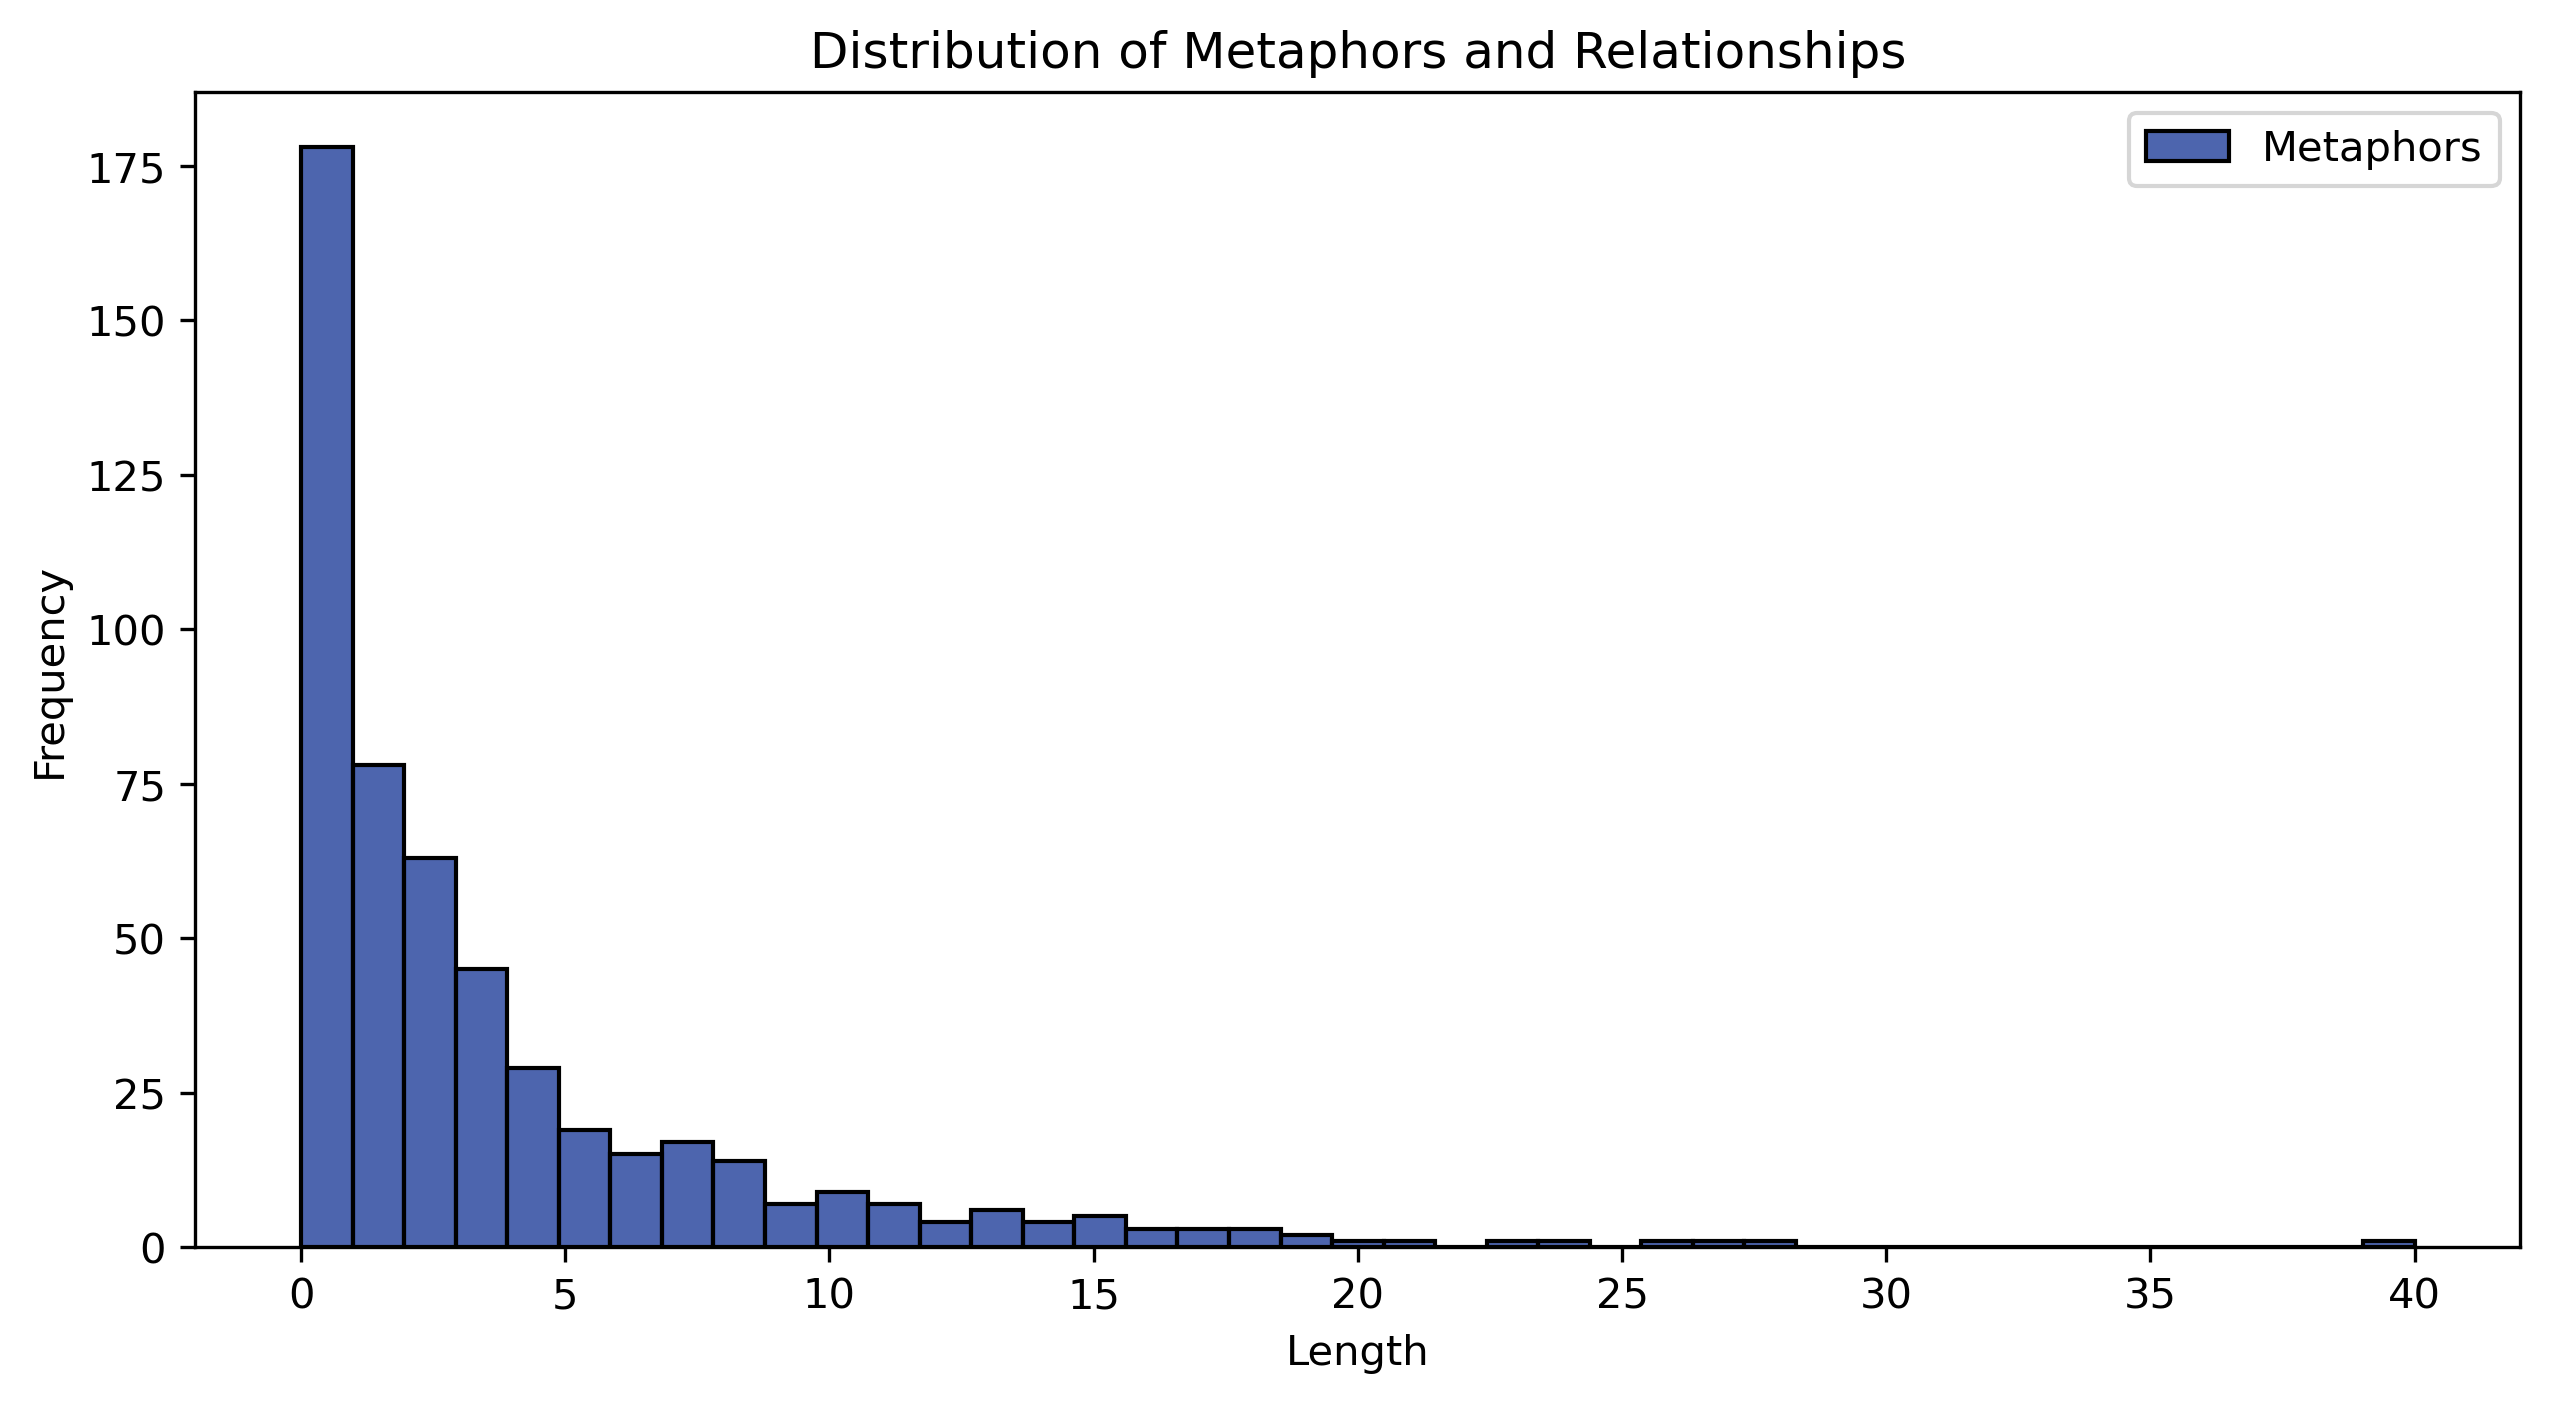

In [18]:
# Plot the length distribution from both columns
plt.figure(figsize=(10, 5), dpi=300)
sns.histplot(data=df, x='pos_metaphors_len', color=color, label='Metaphors')
plt.title('Distribution of Metaphors and Relationships')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

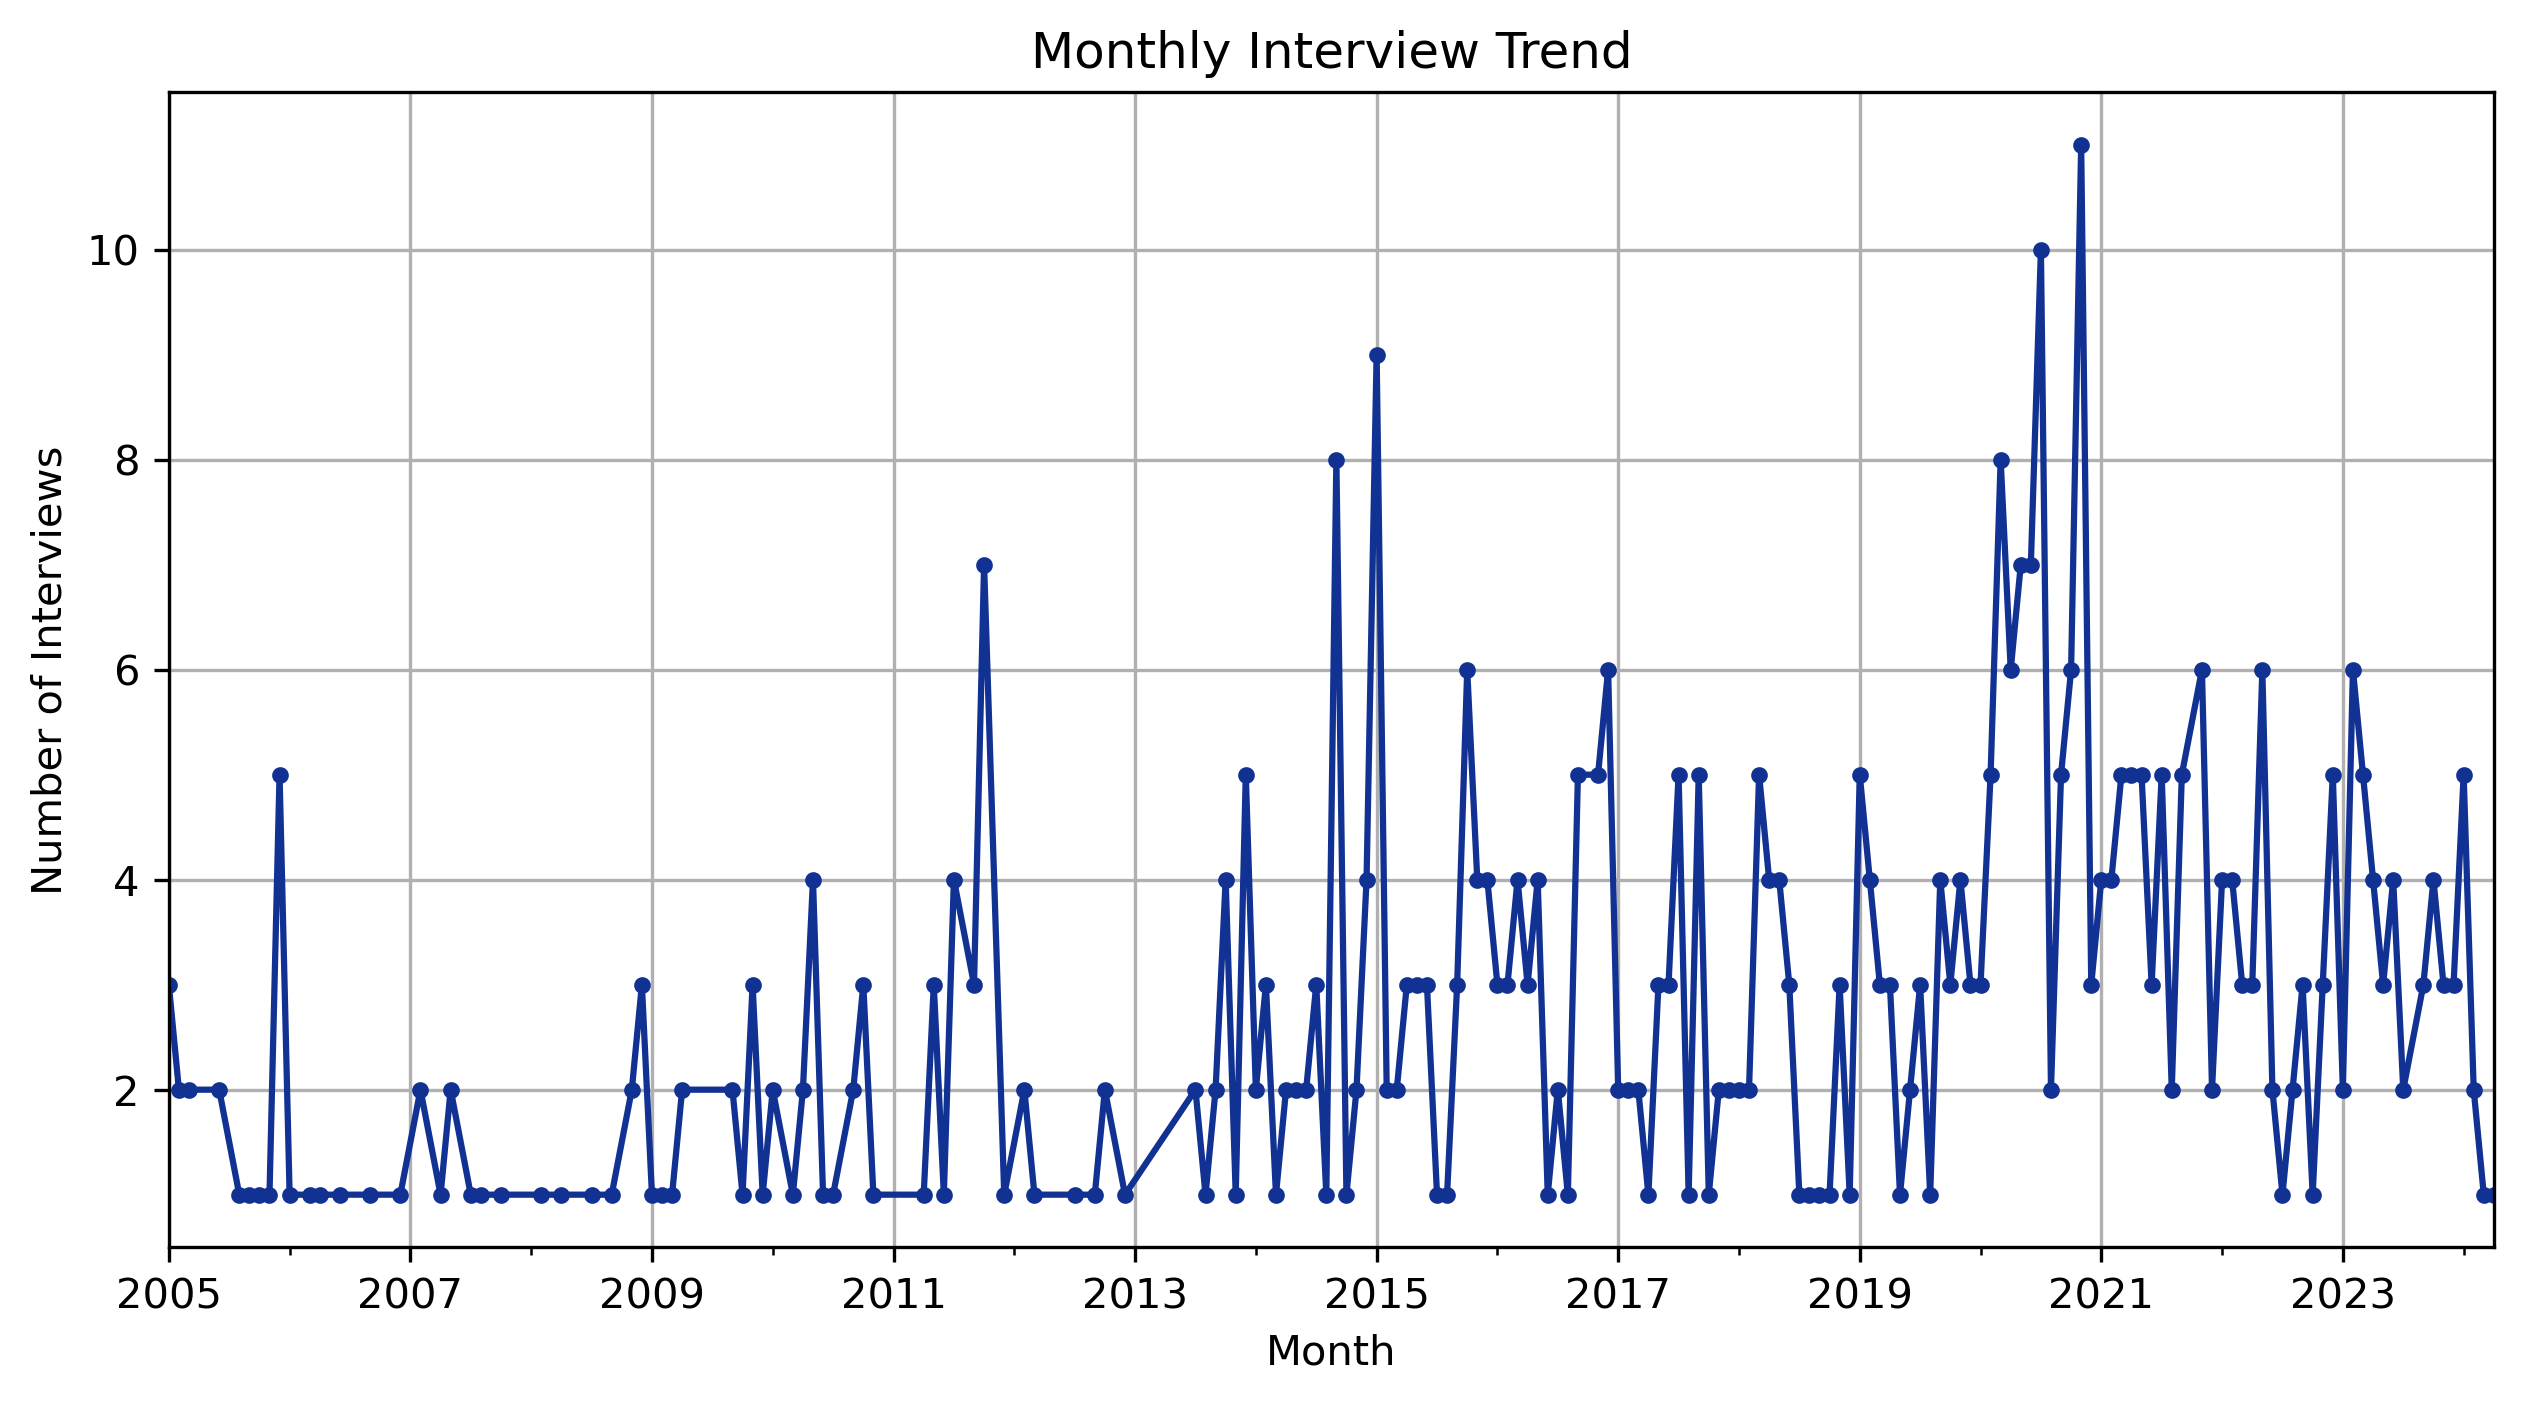

In [19]:
def trend_analysis(df):
    # Group by Year-Month and count entries
    trend_data = df.groupby(df['Date'].dt.to_period('M')).size()
    return trend_data

# Apply the function
monthly_trends = trend_analysis(df)

# Plotting the trend
plt.figure(figsize=(10, 5), dpi=300)
monthly_trends.plot(kind='line', marker='.', title='Monthly Interview Trend', color=color)
plt.xlabel('Month')
plt.ylabel('Number of Interviews')
plt.grid(True)
plt.show()

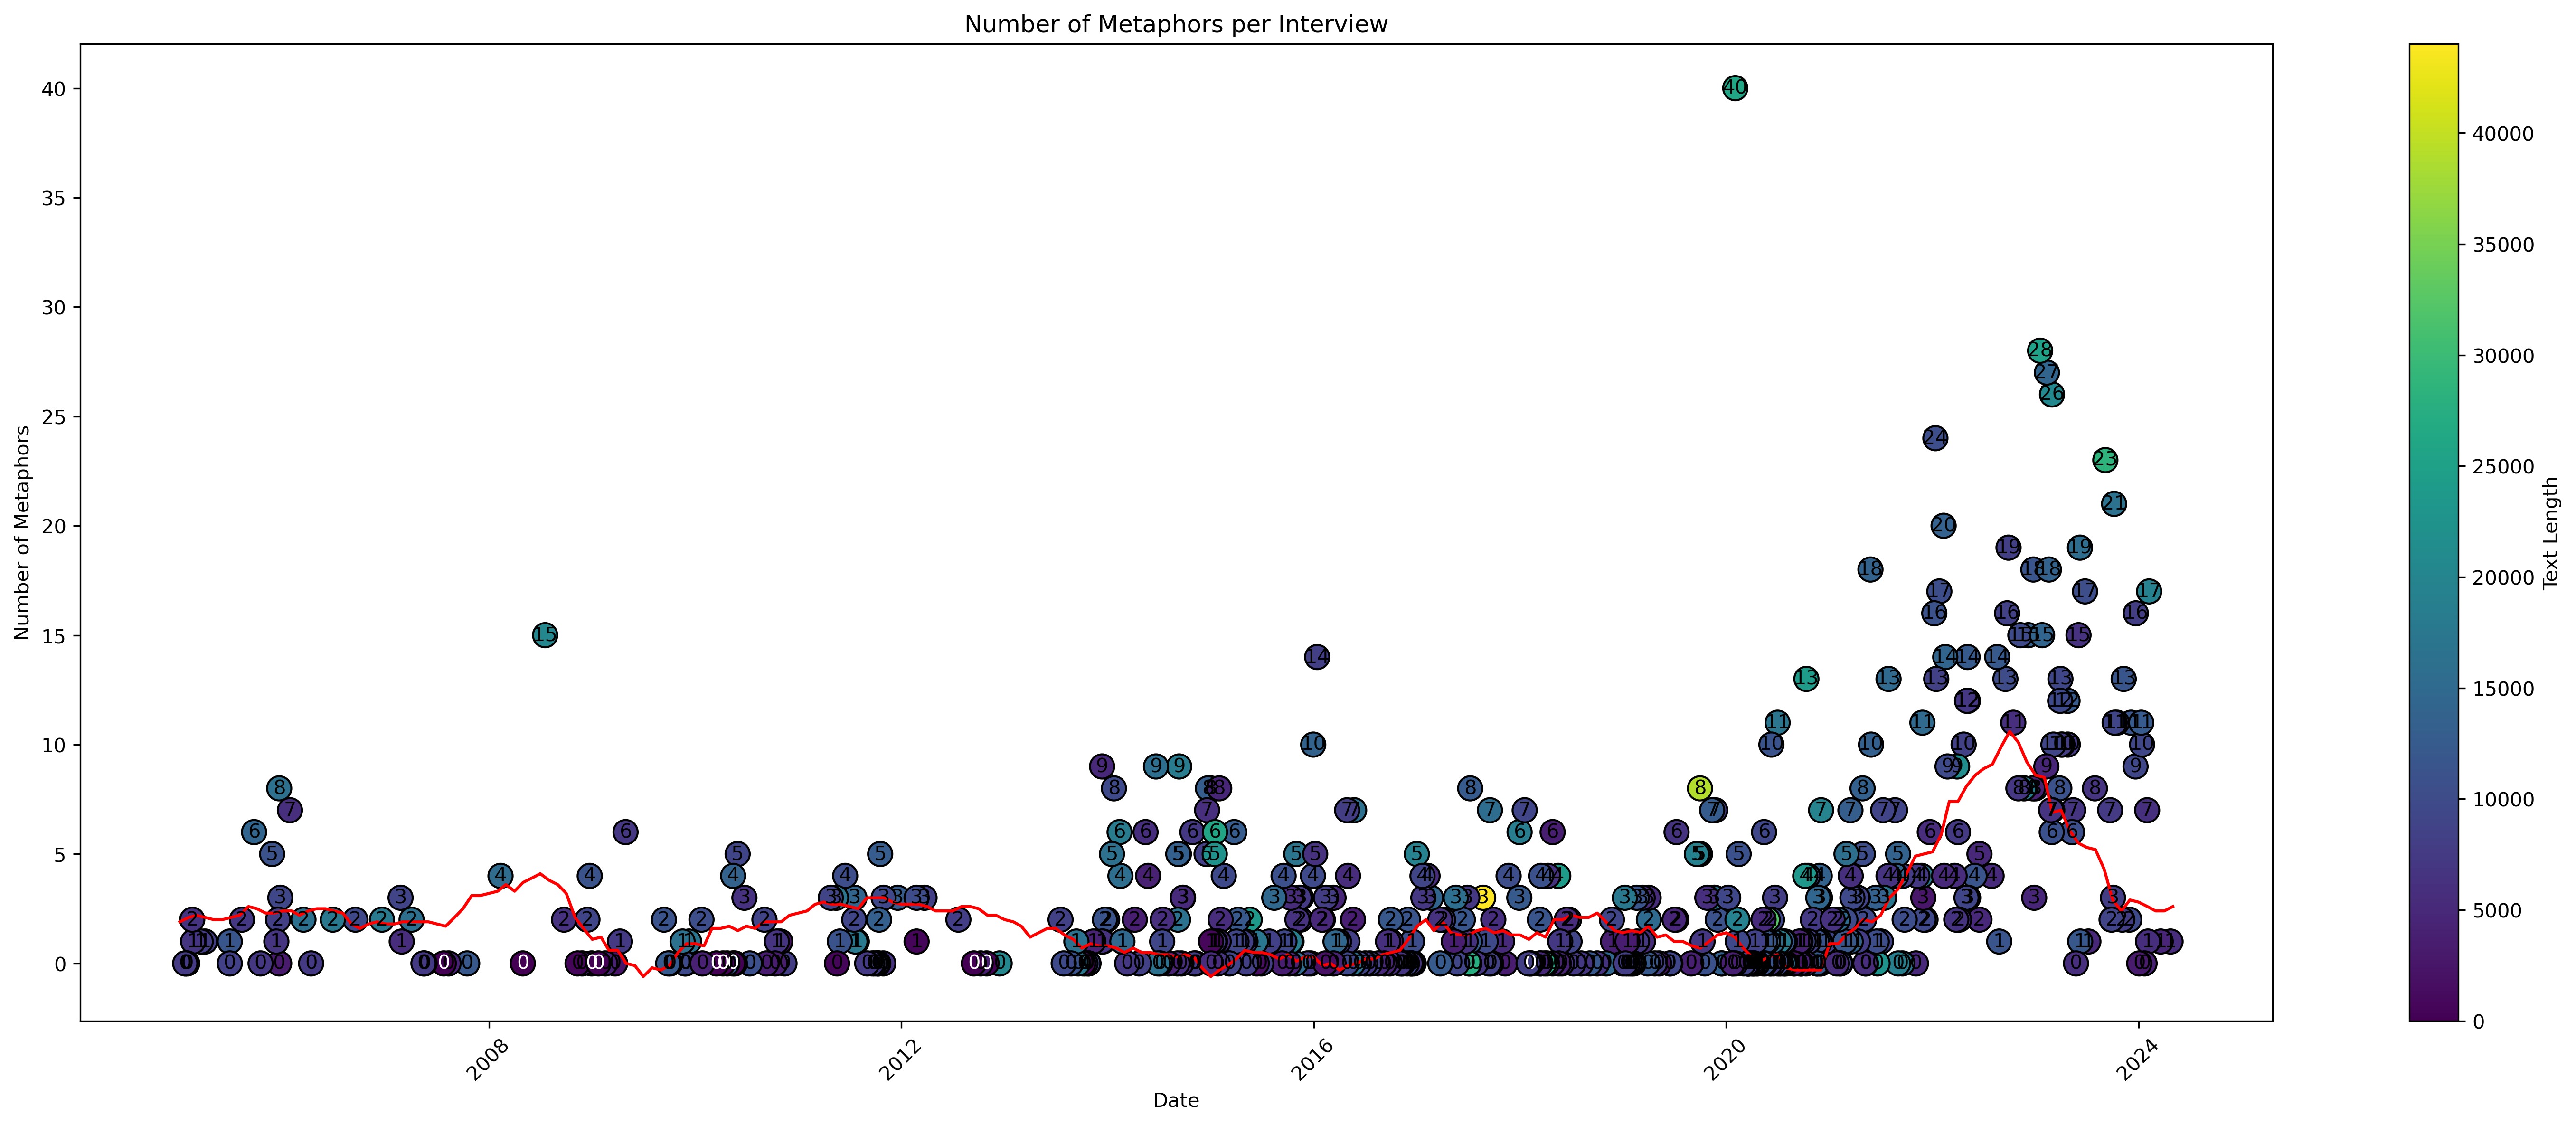

In [20]:
# Defining colors based on text length
norm = mcolors.Normalize(vmin=df['text_length'].min(), vmax=df['text_length'].max())
cmap = plt.cm.get_cmap('viridis')

# Create figure and axes
fig, ax = plt.subplots(figsize=(20, 8), dpi=300)

# Create scatter plot
sc = ax.scatter(df['Date'], df['pos_metaphors_len'], c=df['text_length'], cmap=cmap, norm=norm, s=150, edgecolors='k')

# Add text length colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(df['text_length'])  # Set array to be the range of the colormap
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Text Length')

# Add metaphor count labels inside the points
for i, row in df.iterrows():
    ax.text(row['Date'], row['pos_metaphors_len'], str(row['pos_metaphors_len']), ha='center', va='center', color='white' if row['text_length'] < 0.5 else 'black')

# Plot line for OBS_VALUE from df2
ax.plot(df2['TIME_PERIOD'], df2['OBS_VALUE'], color='red', label='OBS_VALUE')

# Set plot labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Number of Metaphors')
ax.set_title('Number of Metaphors per Interview')

# Rotate x-axis labels for better readability
ax.tick_params(axis='x', rotation=45)

# Show plot
plt.tight_layout()
plt.show()

In [31]:
"""# Save the dataframe
df = df.drop(columns=['pos_relationships','pos_relationships_len'])
df.to_csv("Final_Data.csv", index=False)"""

# Neural Network

We will build and train a simple Neural Network to evaluate it's perfromance in classifying metaphors, which is known to be a complex task.

In [3]:
df_model = pd.read_csv('Data/Prediction_Data.csv')

# Split into training and testing data
train_data, test_data = train_test_split(df_model, test_size=0.2, random_state=42)

print("Length of training data: ", len(train_data))
print("Length of testing data: ", len(test_data))

Length of training data:  2749
Length of testing data:  688


In [5]:
# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data["Sentence"])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_data["Sentence"])
padded_sequences = pad_sequences(sequences, padding='post')

# Define the model
def build_model(vocab_size, embedding_dim=16, max_length=10, dense_layers=[20, 20], optimizer_learning_rate=1e-3,
                activation='relu', dropout_rate=0.5, l1=1e-5, l2=1e-4, init='he_normal'):
    model_nn = Sequential()
    
    # Add the embedding layer
    model_nn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model_nn.add(GlobalAveragePooling1D())
    
    # Add the hidden layers
    for index, layer_size in enumerate(dense_layers):
        if index == 0:
            model_nn.add(Dense(layer_size, activation=activation, 
                               kernel_initializer=init, 
                               kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                               bias_regularizer=regularizers.l2(l2)))
            model_nn.add(LayerNormalization())
            model_nn.add(Dropout(dropout_rate))
        else:
            model_nn.add(Dense(layer_size, activation=activation, kernel_initializer=init,
                               kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
            model_nn.add(LayerNormalization())
            model_nn.add(Dropout(dropout_rate))
    
    # Add the output layer
    model_nn.add(Dense(1, activation='sigmoid', kernel_initializer=init))
    
    # Compile model
    model_nn.compile(optimizer=Adam(learning_rate=optimizer_learning_rate), loss='binary_crossentropy', 
                     metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
    
    return model_nn

# Parameters
vocab_size = 10000  # Size of the vocabulary
embedding_dim = 16  # Dimension of the embedding vectors
max_length = max([len(seq) for seq in padded_sequences])  # Maximum length of the sequences

# Build and compile the model
model_nn = build_model(vocab_size=vocab_size, embedding_dim=embedding_dim, max_length=max_length)

# Display the model architecture
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 147, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 20)                340       
                                                                 
 layer_normalization (LayerN  (None, 20)               40        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                4

In [7]:
# Define the model
model_kr = KerasClassifier(model=model_nn)

print(model_kr.get_params().keys())

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'class_weight'])


In [8]:
# Train the model
model_kr.fit(padded_sequences, train_data['Matched'], epochs=10, batch_size=32)

Epoch 1/10
86/86 [==============================] - 2s 3ms/step - loss: 0.4867 - accuracy: 0.8258 - precision: 0.8666 - recall: 0.9441 - auc: 0.5006
Epoch 2/10
86/86 [==============================] - 0s 3ms/step - loss: 0.4476 - accuracy: 0.8552 - precision: 0.8657 - recall: 0.9857 - auc: 0.4872
Epoch 3/10
86/86 [==============================] - 0s 3ms/step - loss: 0.4286 - accuracy: 0.8625 - precision: 0.8656 - recall: 0.9958 - auc: 0.5249
Epoch 4/10
86/86 [==============================] - 0s 3ms/step - loss: 0.4265 - accuracy: 0.8632 - precision: 0.8660 - recall: 0.9962 - auc: 0.5226
Epoch 5/10
86/86 [==============================] - 0s 3ms/step - loss: 0.4287 - accuracy: 0.8640 - precision: 0.8658 - recall: 0.9975 - auc: 0.5013
Epoch 6/10
86/86 [==============================] - 0s 3ms/step - loss: 0.4242 - accuracy: 0.8643 - precision: 0.8656 - recall: 0.9983 - auc: 0.5161
Epoch 7/10
86/86 [==============================] - 0s 3ms/step - loss: 0.4285 - accuracy: 0.8654 - precis

KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x000001E074715B10>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)

22/22 [==============================] - 0s 1ms/step


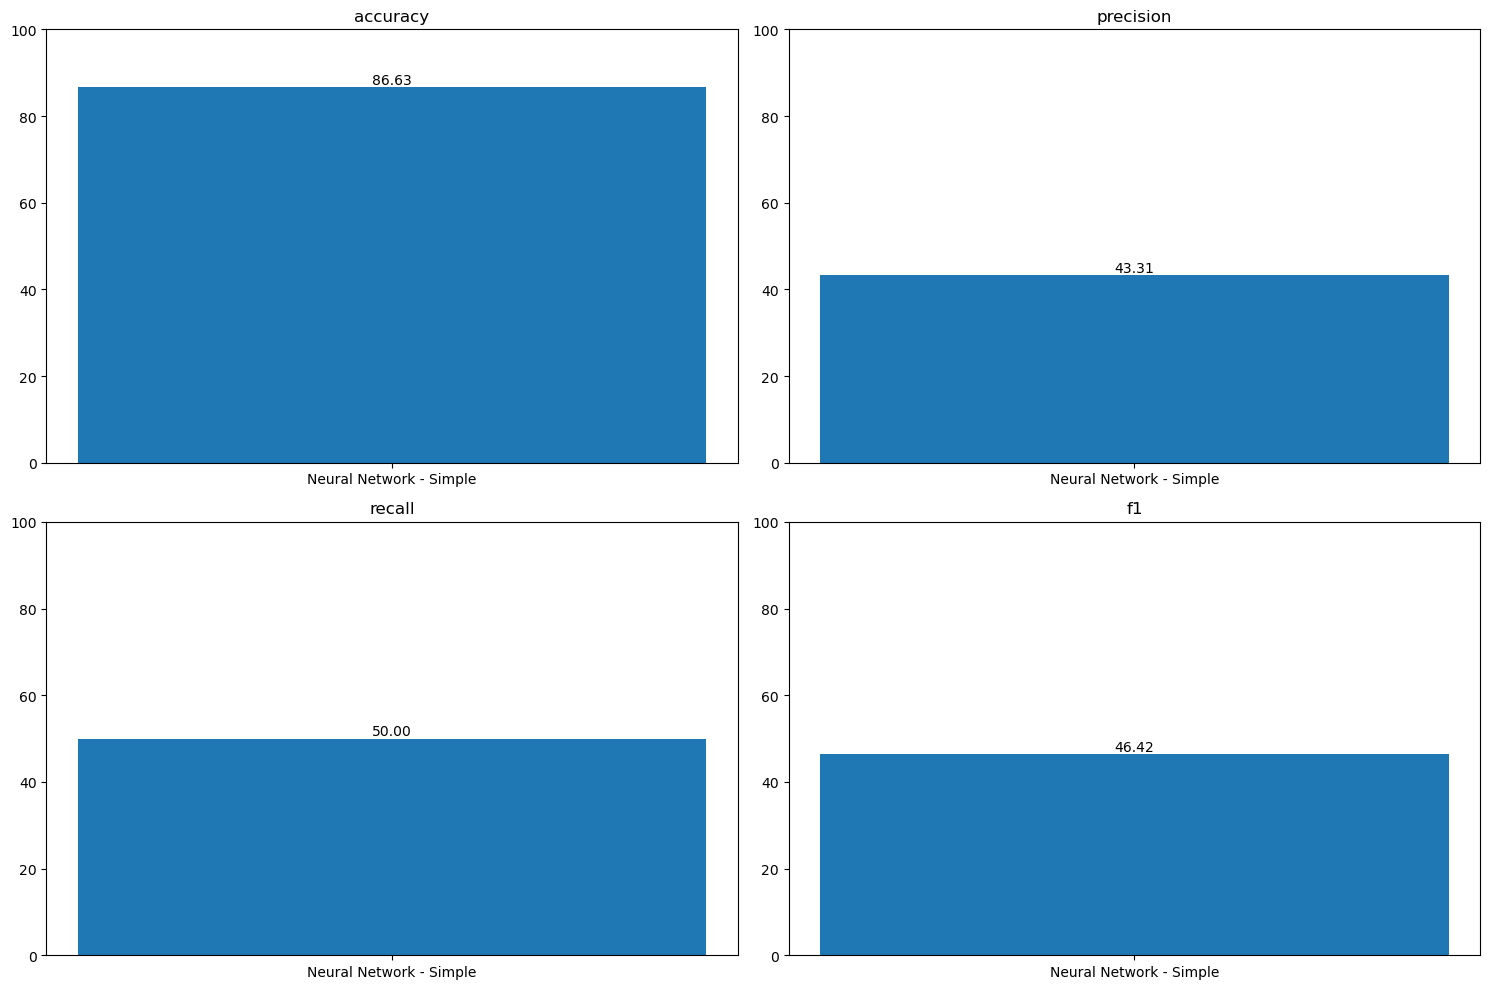

In [11]:
# Evaluate the model
sequences_test = tokenizer.texts_to_sequences(test_data["Sentence"])
padded_sequences_test = pad_sequences(sequences_test, padding='post', maxlen=max_length)

# Predict the test data
y_pred = model_kr.predict(padded_sequences_test)

# Calculate metrics
metrics = Metrics()
metrics.run(test_data['Matched'], y_pred, 'Neural Network - Simple')
metrics.plot()

In [14]:
# Simple NN grid search
param_grid = {
    'dense_layers': [[180, 180], [200, 200], [220, 220]],
    'activation': ['relu'],
    'dropout_rate': [0.5],
    'init': ['he_normal'],
    'l1': [1e-6, 1e-5],
    'l2': [1e-5, 1e-4],
    'learnin_rate': [0.001, 0.0005]
}

histories = []

for dense_layer, activation, dropout_rate, init, l1, l2, learnin_rate in product(*param_grid.values()):
    model_nn = build_model(vocab_size=vocab_size, embedding_dim=embedding_dim, max_length=max_length, dense_layers=dense_layer, activation=activation, dropout_rate=dropout_rate, init=init, l1=l1, l2=l2)
    history = model_nn.fit(padded_sequences, train_data['Matched'], epochs=10, batch_size=32)
    params = {'dense_layer':dense_layer, 'activation':activation, 'dropout_rate':dropout_rate, 'init':init, 'l1':l1, 'l2':l2, 'learnin_rate':learnin_rate}
    accuracy = history.history['accuracy'][-1]
    recall = history.history['recall'][-1]
    histories.append((history, params, accuracy, recall))

Epoch 1/10
86/86 [==============================] - 2s 4ms/step - loss: 0.4857 - accuracy: 0.8494 - precision: 0.8668 - recall: 0.9761 - auc: 0.4919
Epoch 2/10
86/86 [==============================] - 0s 4ms/step - loss: 0.4322 - accuracy: 0.8643 - precision: 0.8658 - recall: 0.9979 - auc: 0.5156
Epoch 3/10
86/86 [==============================] - 0s 4ms/step - loss: 0.4281 - accuracy: 0.8647 - precision: 0.8656 - recall: 0.9987 - auc: 0.4949
Epoch 4/10
86/86 [==============================] - 0s 4ms/step - loss: 0.4118 - accuracy: 0.8661 - precision: 0.8661 - recall: 1.0000 - auc: 0.5366
Epoch 5/10
86/86 [==============================] - 0s 4ms/step - loss: 0.4023 - accuracy: 0.8669 - precision: 0.8673 - recall: 0.9992 - auc: 0.5907
Epoch 6/10
86/86 [==============================] - 0s 4ms/step - loss: 0.3755 - accuracy: 0.8683 - precision: 0.8701 - recall: 0.9966 - auc: 0.6851
Epoch 7/10
86/86 [==============================] - 0s 4ms/step - loss: 0.3288 - accuracy: 0.8774 - precis

In [15]:
# Order the histories by the validation loss
histories = sorted(histories, key=lambda x: x[0].history['accuracy'][-1])

df_histories = pd.DataFrame(histories, columns=['history', 'params', 'accuracy', 'recall'])

# Print the results in order:
results = df_histories
results = results.sort_values(by='accuracy', ascending=False)

means = results['accuracy']
dev = results['recall']
params = results['params']

sorted_indices = sorted(range(len(means)), key=lambda i: means[i], reverse=True)

# Print the top 5 results
for i in sorted_indices[:5]:
    print("%f (%f) with: %r" % (means[i], dev[i], params[i]))

0.945798 (0.977731) with: {'dense_layer': [200, 200], 'activation': 'relu', 'dropout_rate': 0.5, 'init': 'he_normal', 'l1': 1e-05, 'l2': 0.0001, 'learnin_rate': 0.0005}
0.937796 (0.981092) with: {'dense_layer': [220, 220], 'activation': 'relu', 'dropout_rate': 0.5, 'init': 'he_normal', 'l1': 1e-05, 'l2': 0.0001, 'learnin_rate': 0.0005}
0.936341 (0.972689) with: {'dense_layer': [220, 220], 'activation': 'relu', 'dropout_rate': 0.5, 'init': 'he_normal', 'l1': 1e-06, 'l2': 0.0001, 'learnin_rate': 0.001}
0.927610 (0.976050) with: {'dense_layer': [180, 180], 'activation': 'relu', 'dropout_rate': 0.5, 'init': 'he_normal', 'l1': 1e-06, 'l2': 1e-05, 'learnin_rate': 0.001}
0.924336 (0.973109) with: {'dense_layer': [200, 200], 'activation': 'relu', 'dropout_rate': 0.5, 'init': 'he_normal', 'l1': 1e-06, 'l2': 0.0001, 'learnin_rate': 0.001}


Epoch 1/10
86/86 [==============================] - 2s 6ms/step - loss: 0.6513 - accuracy: 0.8345 - precision: 0.8664 - recall: 0.9563 - auc: 0.4872
Epoch 2/10
86/86 [==============================] - 0s 3ms/step - loss: 0.5428 - accuracy: 0.8596 - precision: 0.8652 - recall: 0.9924 - auc: 0.5272
Epoch 3/10
86/86 [==============================] - 0s 3ms/step - loss: 0.5293 - accuracy: 0.8647 - precision: 0.8656 - recall: 0.9987 - auc: 0.5011
Epoch 4/10
86/86 [==============================] - 0s 3ms/step - loss: 0.5092 - accuracy: 0.8654 - precision: 0.8660 - recall: 0.9992 - auc: 0.5464
Epoch 5/10
86/86 [==============================] - 0s 3ms/step - loss: 0.4954 - accuracy: 0.8658 - precision: 0.8660 - recall: 0.9996 - auc: 0.5721
Epoch 6/10
86/86 [==============================] - 0s 3ms/step - loss: 0.4769 - accuracy: 0.8665 - precision: 0.8672 - recall: 0.9987 - auc: 0.6443
Epoch 7/10
86/86 [==============================] - 0s 3ms/step - loss: 0.4186 - accuracy: 0.8752 - precis

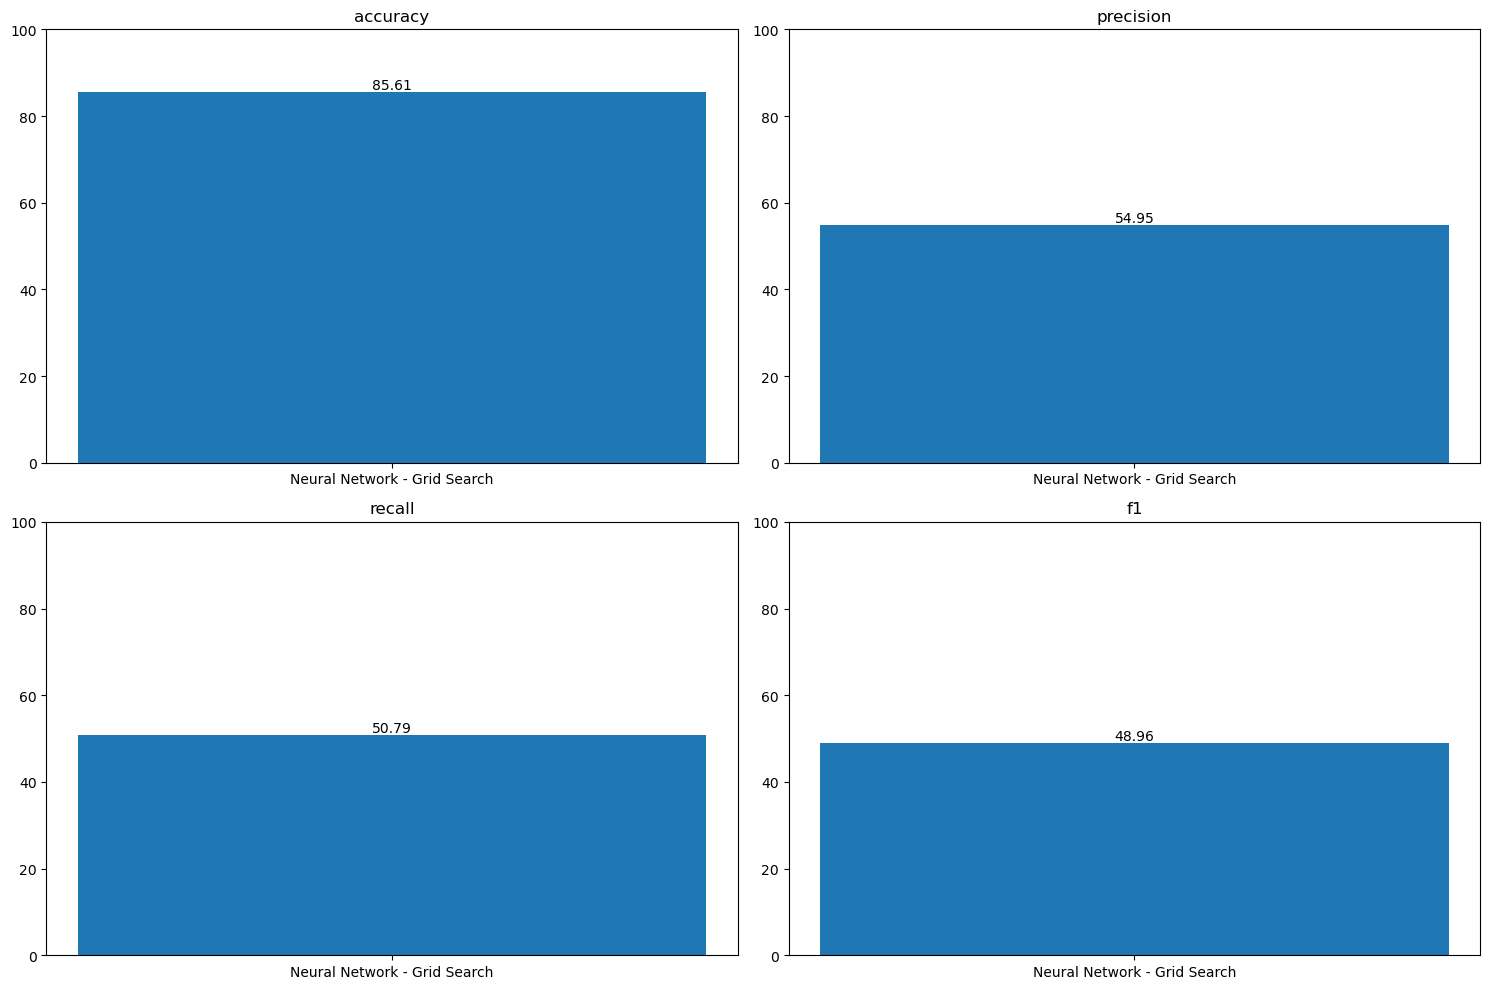

In [18]:
# Get the best model
best_params = results.iloc[0]['params']

dense_layers = best_params['dense_layer']
activation = best_params['activation']
dropout_rate = best_params['dropout_rate']
init = best_params['init']
l1 = best_params['l1']
l2 = best_params['l2']
learnin_rate = best_params['learnin_rate']

# Build the best model
model_nn = build_model(vocab_size=vocab_size, embedding_dim=embedding_dim, max_length=max_length, dense_layers=dense_layers, activation=activation, dropout_rate=dropout_rate, init=init, l1=l1, l2=l2)

# Train the best model
model_nn.fit(padded_sequences, train_data['Matched'], epochs=10, batch_size=32)

# Predict the test data
y_pred = model_nn.predict(padded_sequences_test)

# Calculate metrics
metrics = Metrics()
metrics.run(test_data['Matched'], y_pred, 'Neural Network - Grid Search', proba=True)
metrics.plot()

108/108 [==============================] - 0s 1ms/step


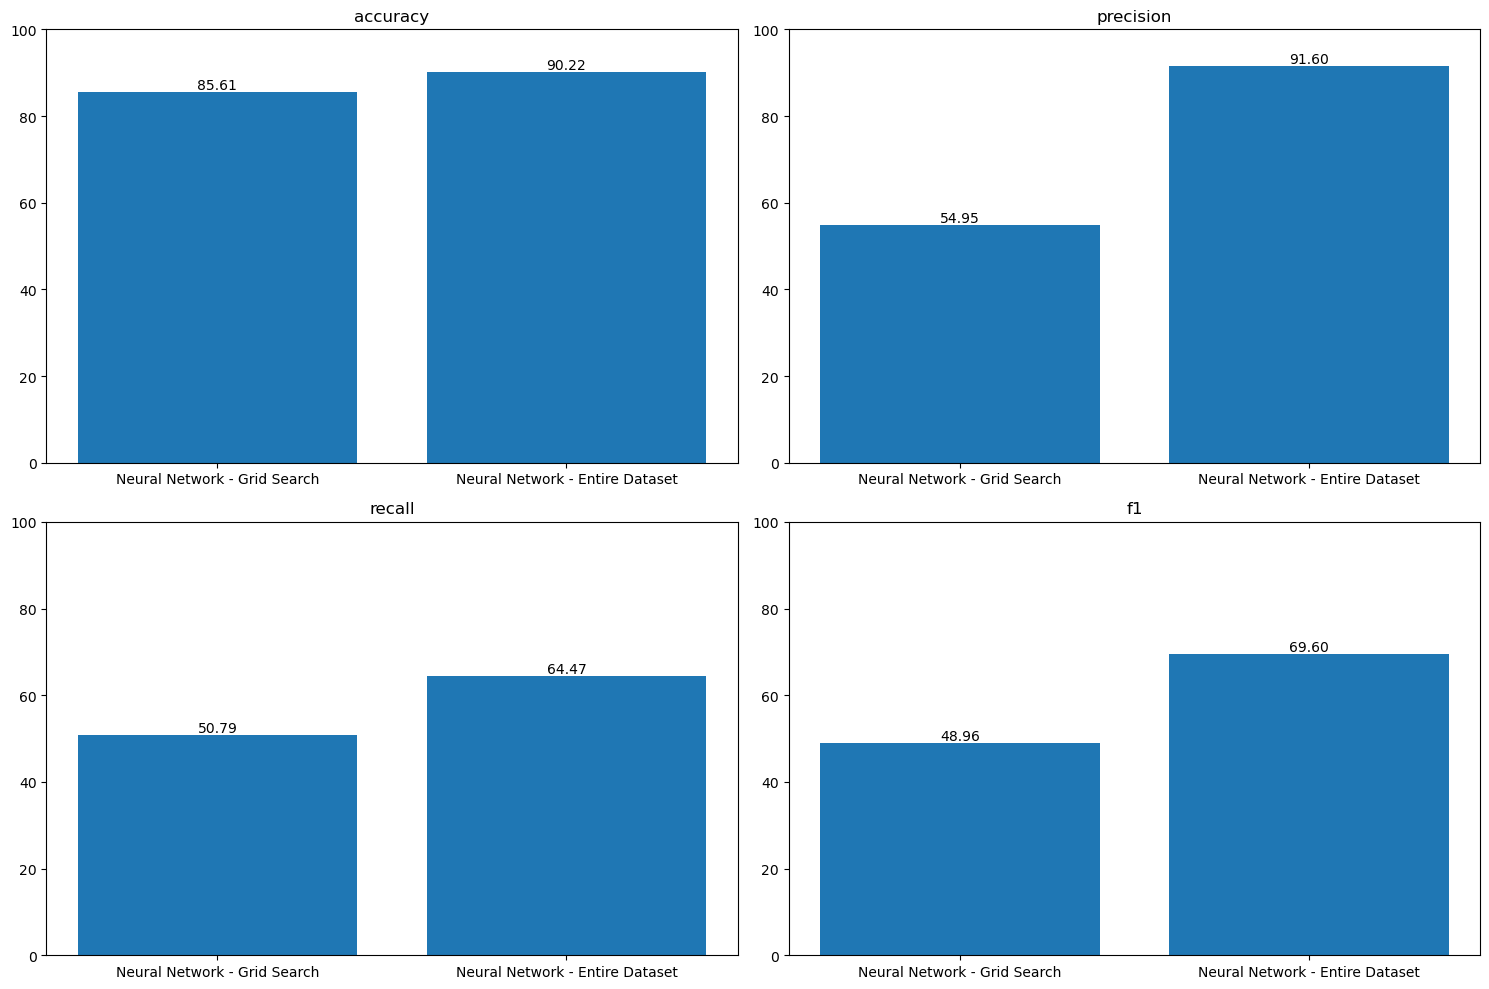

In [19]:
# Predict on the entire dataset and save the results
sequences_all = tokenizer.texts_to_sequences(df_model["Sentence"])

padded_sequences_all = pad_sequences(sequences_all, padding='post', maxlen=max_length)

# Predict the entire dataset
y_pred_all = model_nn.predict(padded_sequences_all)

# Change the predictions to binary True/False
y_pred_all = [True if pred > 0.5 else False for pred in y_pred_all]

# Save the results
df_model['Predicted_NN'] = y_pred_all

# Evaluate the model on the entire dataset
metrics.run(df_model['Matched'], df_model['Predicted_NN'], 'Neural Network - Entire Dataset')
metrics.plot()

# Large Language Model

We will train a large language model (distilbert-base-uncased) on part of our data and evaluate it's metrics.

In [24]:
def get_batches(X_train, y_train, tokenizer, batch_size, max_length):
    """
    Objective: Create a generator that yields batches of tokenized text and corresponding labels.
               The data is shuffled and looped through indefinitely.

    Inputs:
        - X_train (np.array): Array of text data (features).
        - y_train (np.array): Array of labels.
        - tokenizer (DistilBertTokenizer): Tokenizer for text data.
        - batch_size (int): Size of each batch.
        - max_length (int): Maximum length of tokenized sequences.
    Outputs:
        - Generator yielding batches of (inputs, targets).
    """

    # Pre-tokenize the entire dataset
    inputs = tokenizer.batch_encode_plus(list(X_train), add_special_tokens=True, max_length=max_length,
                                         padding='max_length', return_attention_mask=True,
                                         return_token_type_ids=True, truncation=True,
                                         return_tensors="np")

    input_ids = np.asarray(inputs['input_ids'], dtype='int32')
    attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')

    # Shuffle and yield batches
    while True:
        X_train, y_train, input_ids, attention_masks = shuffle(X_train, y_train, input_ids, attention_masks, random_state=42)

        for i in range(0, len(X_train), batch_size):
            yield [input_ids[i:i + batch_size], attention_masks[i:i + batch_size]], y_train[i:i + batch_size]

In [22]:
# Import Bert model
checkpoint="distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint, output_attentions=True)

batch_size=35
max_length=35
rate = 0.5 # dropout parameters
num_labels = 2

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


First, we will freez the learning layer to warm-up the pre-trained BERT model to leverage the knowledge.

In [23]:
## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers
embedding_layer = model(input_ids_in, attention_mask=input_masks_in)[0][:,0,:]
output_layer = tf.keras.layers.Dropout(rate)(embedding_layer)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)


bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)
# To freeze BERT parameters (look at the trainable parameters below)
bert_model.layers[2].trainable = False
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 35)]         0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 35)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 35, 768),                                                    
                                 hidden_states=None                                           

In [27]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(train_data["Matched"].values.reshape(-1, 1)).toarray()

In [28]:
X_train = train_data['Sentence']
X_test = test_data['Sentence']

steps_per_epoch = int(len(X_train)/batch_size)

## Warm-up for 5 epochs
# Training is going 3 times faster without BERT training
bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)


# TODO: Change the number of epochs
bert_model.fit(batches, epochs=5, steps_per_epoch=steps_per_epoch)
# CPU: 4min11s

Epoch 1/5
78/78 [==============================] - 55s 631ms/step - loss: 1.1441 - recall: 0.3601 - precision: 0.3601
Epoch 2/5
78/78 [==============================] - 54s 699ms/step - loss: 0.9448 - recall: 0.4385 - precision: 0.4385
Epoch 3/5
78/78 [==============================] - 55s 705ms/step - loss: 0.7864 - recall: 0.5387 - precision: 0.5387
Epoch 4/5
78/78 [==============================] - 49s 628ms/step - loss: 0.6862 - recall: 0.6142 - precision: 0.6142
Epoch 5/5
78/78 [==============================] - 49s 634ms/step - loss: 0.6067 - recall: 0.6835 - precision: 0.6835


In [30]:
# Test the model
inputs = tokenizer.batch_encode_plus(list(test_data["Sentence"]),
                                    add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]

test_preds = bert_model.predict(inputs_test)
test_preds = np.argmax(test_preds, axis=1)

metrics = Metrics()
# get the final metrics
metrics.run(test_data["Matched"], test_preds, "distilBERT frozen + Softmax")

22/22 [==============================] - 12s 467ms/step


Unfreezed Model:

In [29]:
bert_model.layers[2].trainable = True
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 35)]         0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 35)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 35, 768),                                                    
                                 hidden_states=None                                           

In [31]:
# Train on the whole NN
batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# TODO: Change nbr of epochs
bert_model.fit(batches, epochs=5, steps_per_epoch=steps_per_epoch)
# CPU: 16min

Epoch 1/5
78/78 [==============================] - 210s 3s/step - loss: 0.4023 - recall_1: 0.8612 - precision_1: 0.8612
Epoch 2/5
78/78 [==============================] - 190s 2s/step - loss: 0.3593 - recall_1: 0.8651 - precision_1: 0.8651
Epoch 3/5
78/78 [==============================] - 194s 2s/step - loss: 0.3225 - recall_1: 0.8703 - precision_1: 0.8703
Epoch 4/5
78/78 [==============================] - 195s 2s/step - loss: 0.2524 - recall_1: 0.8931 - precision_1: 0.8931
Epoch 5/5
78/78 [==============================] - 208s 3s/step - loss: 0.1400 - recall_1: 0.9436 - precision_1: 0.9436


22/22 [==============================] - 16s 652ms/step


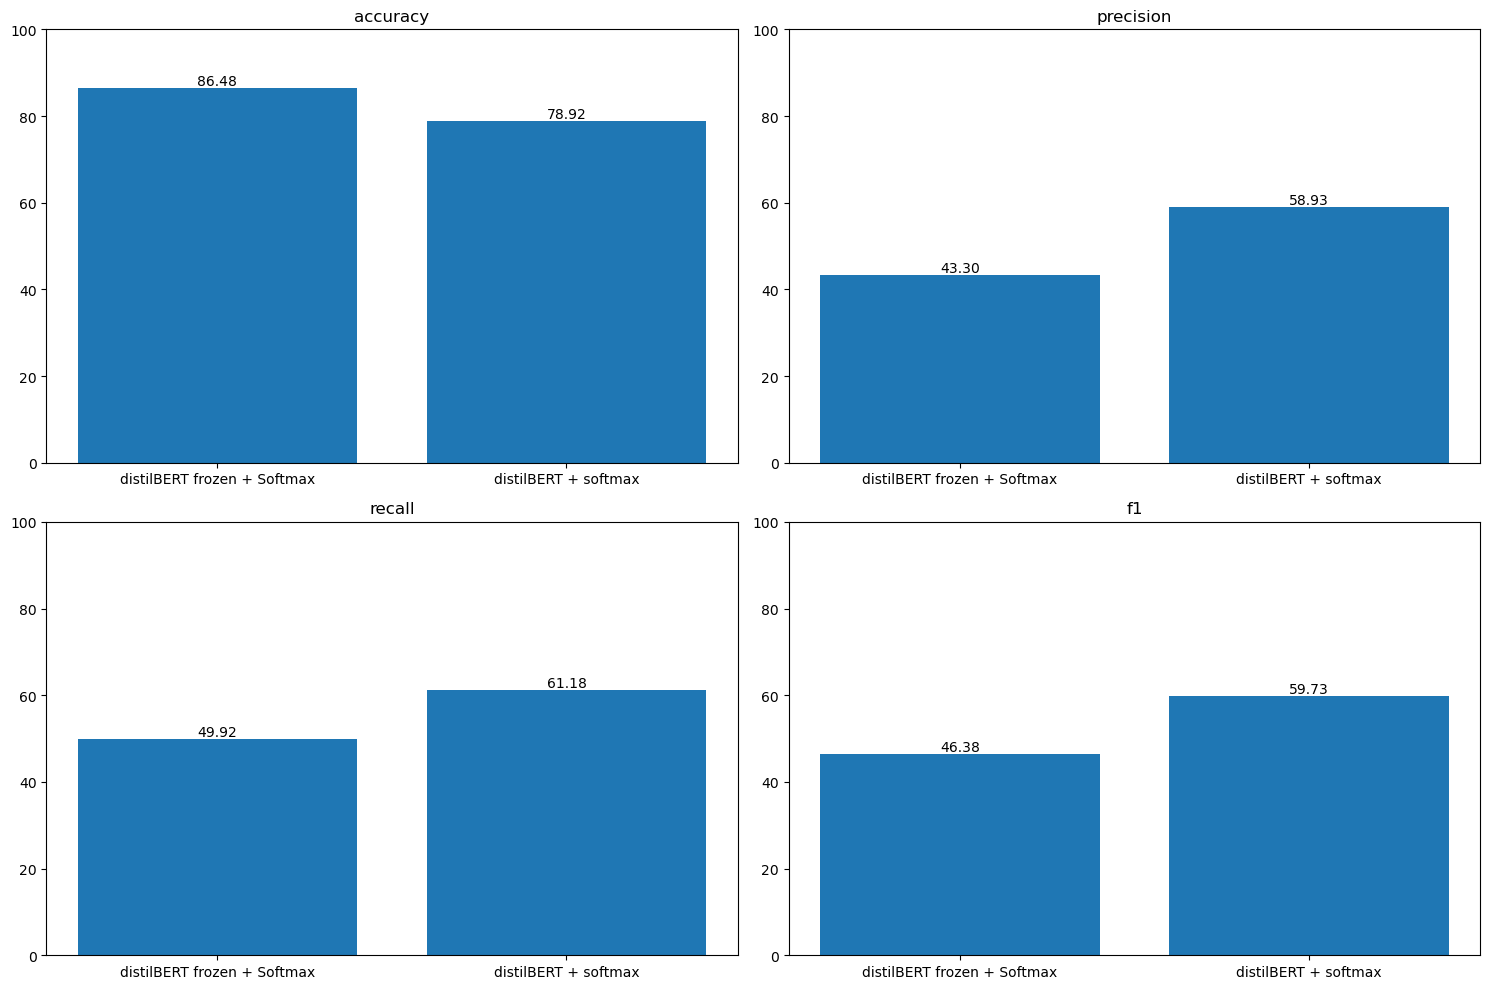

In [32]:
# Get the inputs tokenized from the test set
inputs = tokenizer.batch_encode_plus(list(test_data["Sentence"]),
                                    add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
test_preds = bert_model.predict(inputs_test)
test_preds = np.argmax(test_preds, axis=1)

# get the final metrics
metrics.run(test_data["Matched"], test_preds, "distilBERT + softmax")
metrics.plot()

108/108 [==============================] - 66s 613ms/step


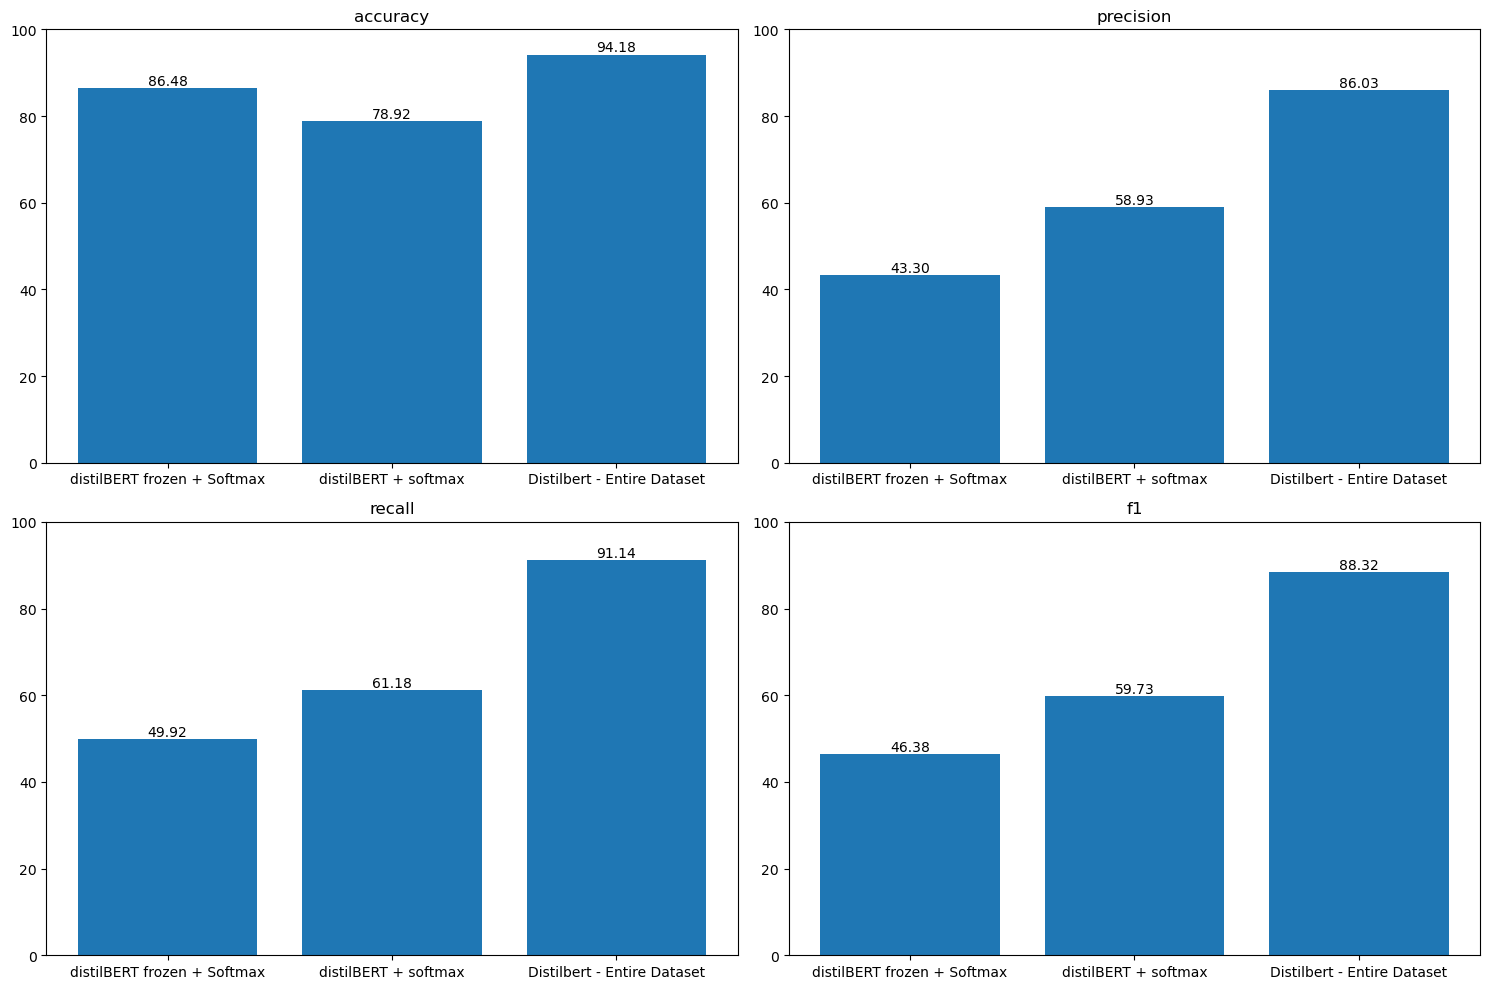

In [33]:
# Predict on the entire dataset
inputs_all = tokenizer.batch_encode_plus(list(df_model["Sentence"]),
                                    add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_all = [np.asarray(inputs_all['input_ids'], dtype='int32'),
               np.asarray(inputs_all['attention_mask'], dtype='int32')]

# Predict the entire dataset
y_pred_all = bert_model.predict(inputs_all)
y_pred_all = np.argmax(y_pred_all, axis=1)

# Change 0 and 1 to False and True
y_pred_all = [False if pred == 0 else True for pred in y_pred_all]

# Save the results
df_model["Predicted_LLM"] = y_pred_all

# Evaluate the model on the entire dataset
metrics.run(df_model['Matched'], df_model['Predicted_LLM'], 'Distilbert - Entire Dataset')
metrics.plot()

In [ ]:
"""# Save the results
df_model.to_csv('Data/Prediction_Data.csv', index=False)"""